In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [1]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file = '../data/Hz31.txt'
data = pd.read_csv(file, names=['z', 'hz', 'err'], sep = " " )
data.describe()

,z,hz,err
count,31.000000,31.000000,31.000000
mean,0.661219,105.922581,21.303226
std,0.520398,38.413424,14.587768
min,0.070000,68.600000,4.000000
25%,0.275000,78.950000,12.000000
50%,0.470000,90.000000,17.000000
75%,0.890000,121.000000,27.900000
max,1.965000,202.000000,62.000000


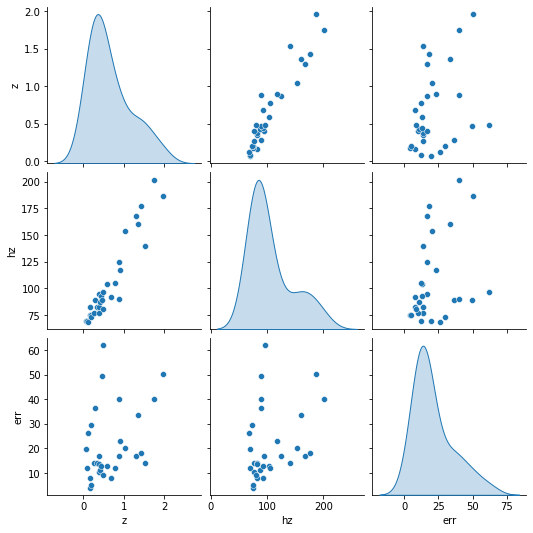

In [3]:
sns.pairplot(data, diag_kind="kde")
# plt.savefig("DistHD.png")

In [4]:
# a = np.array([25,  3,  9,  7, 19,  2, 17, 16,  6, 28, 12, 20, 21, 26, 27, 11,  1,
#        10, 30, 13, 29,  0,  8, 18, 24,  5, 23,  4, 22, 15, 14])
# randomize = np.random.permutation(len(data.values))
shuffle = [x for x in range(len(data.values)) if x%2 ==0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)

data = data.values[shuffle]
# shuffle

In [5]:
# def norm(x):
#     return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)


Read the data for cosmic chronometers

In [6]:

# odds = [x for x in range(len(data)) if x%2 ==0]
# even = [x for x in range(len(data)) if x%2 ==1]
# new_order = np.array(even+odds)
# new_order = np.array([x for x in range(len(data)-1, 0, -1)])
# data = data.values[new_order]
# data = data.values


In [7]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [8]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [9]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [10]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=50.0,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]
# initializer = Constant(value=0.01)
# initializer = RandomNormal()
#     efirst = Dense(150, activation='relu', input_shape=(1,))(input_z)
#     ehidden = Dense(50, activation='relu')(efirst)
# #     ehidden = Dense(150, activation='relu')(efirst)
#     ehidden2 = Dense(150, activation='relu')(ehidden)
#     ehidden2 = Dense(150, activation='relu')(ehidden2)
#     elast = Dense(2, activation='relu')(ehidden2)



In [27]:
def model(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(200, activation='relu')(efirst)
    ehidden2 = Dense(150, activation='relu')(ehidden)
    elast = Dense(2, activation='linear')(ehidden2)


    return elast


input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                100       
_________________________________________________________________
dense_13 (Dense)             (None, 200)               10200     
_________________________________________________________________
dense_14 (Dense)             (None, 150)               30150     
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 302       
Total params: 40,752
Trainable params: 40,752
Non-trainable params: 0
_________________________________________________________________


In [28]:
# batch_size = 4
batch_size = 4
epochs = 100
input_z = Input(shape = (1,))

In [29]:
# autoencoder = Model(input_z, autoencoder(input_z))
# autoencoder.compile(loss='mean_squared_error', optimizer = "adam")
# autoencoder.summary()

In [30]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))
#                                     callbacks=callbacks)

Epoch 1/100
6/6 [==============================] - 0s 15ms/step - loss: 5165.4579 - val_loss: 10964.2012
Epoch 2/100
6/6 [==============================] - 0s 4ms/step - loss: 5158.7461 - val_loss: 10882.1191
Epoch 3/100
6/6 [==============================] - 0s 4ms/step - loss: 4408.9229 - val_loss: 10780.1221
Epoch 4/100
6/6 [==============================] - 0s 4ms/step - loss: 4584.2212 - val_loss: 10620.9287
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 5006.3571 - val_loss: 10369.1270
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 5095.2146 - val_loss: 10003.0459
Epoch 7/100
6/6 [==============================] - 0s 4ms/step - loss: 4637.7634 - val_loss: 9468.7021
Epoch 8/100
6/6 [==============================] - 0s 4ms/step - loss: 5440.1506 - val_loss: 8712.5957
Epoch 9/100
6/6 [==============================] - 0s 4ms/step - loss: 4169.0677 - val_loss: 7749.2144
Epoch 10/100
6/6 [==============================] - 0s 4ms/step - 

6/6 [==============================] - 0s 4ms/step - loss: 120.5533 - val_loss: 327.1655
Epoch 82/100
6/6 [==============================] - 0s 4ms/step - loss: 109.2346 - val_loss: 389.6466
Epoch 83/100
6/6 [==============================] - 0s 4ms/step - loss: 109.1984 - val_loss: 372.4150
Epoch 84/100
6/6 [==============================] - 0s 4ms/step - loss: 125.5399 - val_loss: 335.4787
Epoch 85/100
6/6 [==============================] - 0s 4ms/step - loss: 124.6370 - val_loss: 331.6900
Epoch 86/100
6/6 [==============================] - 0s 4ms/step - loss: 135.6158 - val_loss: 357.2946
Epoch 87/100
6/6 [==============================] - 0s 4ms/step - loss: 118.3411 - val_loss: 346.3959
Epoch 88/100
6/6 [==============================] - 0s 4ms/step - loss: 125.6065 - val_loss: 346.9480
Epoch 89/100
6/6 [==============================] - 0s 4ms/step - loss: 141.4471 - val_loss: 379.0634
Epoch 90/100
6/6 [==============================] - 0s 4ms/step - loss: 141.5386 - val_loss: 39

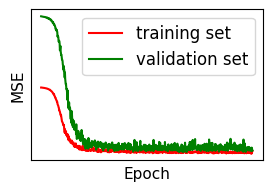

In [106]:
plt.figure(figsize=(3, 2), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.xticks([])
plt.yticks([])
# plt.savefig('loss_hz.png')

In [32]:
# neural_model.save('FFNN_Hz.h5')

In [33]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
print(np.min(model_train.history['loss']), np.min(model_train.history['val_loss']))
# print(model_train.history['loss'][-1], model_train.history['val_loss'][-1])
# 119.81427764892578 311.0423889160156 120 epochs
# 120.7300033569336 355.0390930175781
dif_loss = model_train.history['val_loss'][-1] - model_train.history['val_loss'][-2]
val_loss = model_train.history['val_loss'][-1]
dif_loss, val_loss

123.12979888916016 314.4055480957031


(-1.949462890625, 329.2847595214844)

In [34]:
pred = neural_model.predict(z_test)
pred

array([[ 89.33372 ,  18.38824 ],
       [100.31557 ,  20.562412],
       [111.27648 ,  22.739077],
       [112.87721 ,  23.062979],
       [142.63881 ,  29.118105],
       [152.58017 ,  31.142725],
       [177.29611 ,  36.17706 ]], dtype=float32)

In [35]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [36]:
# ranz = np.random.uniform(0, 2, size=10000)
ranz = np.linspace(0, 2, 1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


(0.0, 2.0)

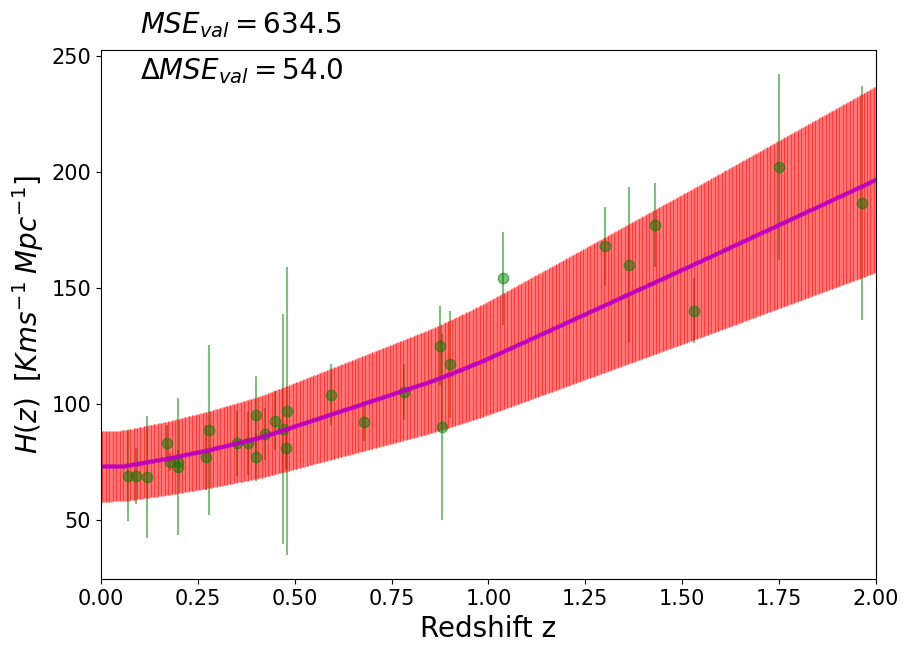

In [37]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m')
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.text( 0.1, 260, "$MSE_{val} =  634.5$", fontsize=20 )
plt.text( 0.1, 240, "$\Delta MSE_{val} = 54.0$", fontsize=20 )
plt.ylabel("$H(z) \;\; [Kms^{-1} \; Mpc^{-1}]$", fontsize=20)
plt.xlim(0, 2)
# plt.savefig("20_epochs_HD.png")

In [38]:
# Cosmological constants
Om = 0.27
# variance network


In [39]:
def Hlcdm(z, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

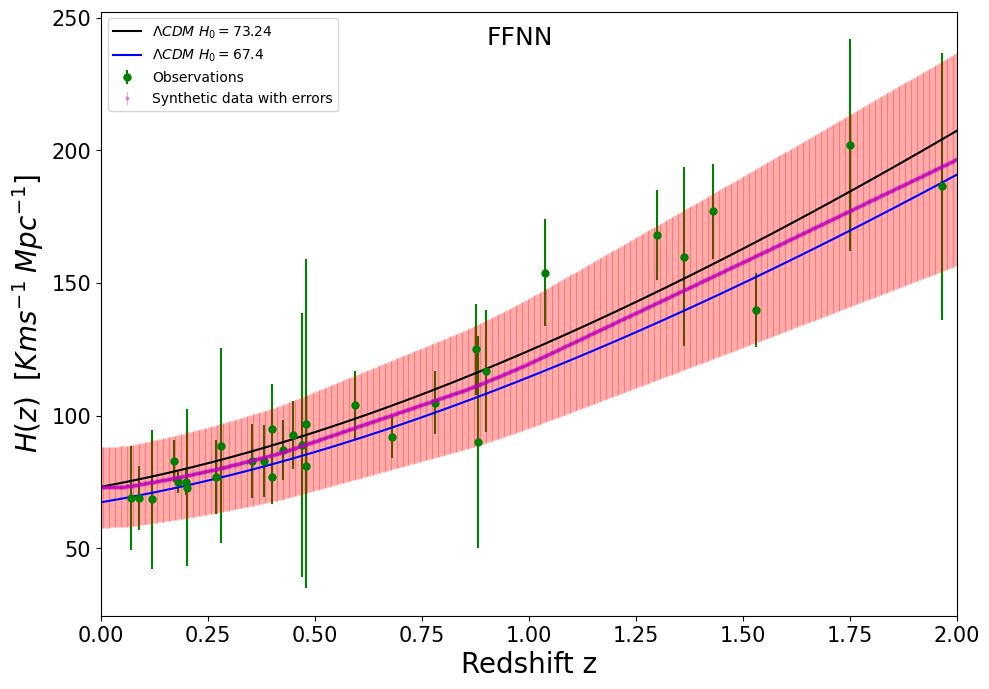

In [117]:
plt.figure(figsize=(10, 7), dpi=100)

zmodel = np.linspace(0, 2, 1000)
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')

plt.errorbar(rr, pred_random[:,0], pred_random[:,1], markersize=2., fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with errors')

plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.text(0.9, 240, 'FFNN', fontsize=18)

plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel("$H(z) \;\; [Kms^{-1} \; Mpc^{-1}]$", fontsize=20)
plt.yticks(fontsize=15)
plt.xlim(0, 2)
plt.tight_layout()
plt.legend(loc='upper left')


plt.savefig("SyntheticHDrelu5.png")

## $H_0$

In [41]:
h0 = pred_random[0,:]
h0

array([73.030914, 15.189981], dtype=float32)

In [42]:
pred_random.shape, r.shape

((1000, 2), (1000, 1))

In [43]:
# randomselection = np.random.randint(0,1000,50)
# randomselection = np.random.randint(0,1000,100)

# rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]

# predy_reduced = pred_random[randomselection,:]
rr_reduced = rr
predy_reduced = pred_random

In [44]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)


# np.savetxt("autoEncoderHz50.dat",mookHz, delimiter=" ")

In [45]:
predy_reduced[:,1]

array([15.189981 , 15.191226 , 15.192471 , 15.193716 , 15.194956 ,
       15.196204 , 15.197449 , 15.198691 , 15.199936 , 15.201181 ,
       15.202423 , 15.20367  , 15.204913 , 15.206158 , 15.207403 ,
       15.208646 , 15.211027 , 15.213575 , 15.216127 , 15.218676 ,
       15.221222 , 15.223772 , 15.226322 , 15.22887  , 15.231453 ,
       15.235342 , 15.239284 , 15.244167 , 15.249044 , 15.254503 ,
       15.260393 , 15.26628  , 15.273478 , 15.2816925, 15.290362 ,
       15.300019 , 15.310702 , 15.321951 , 15.333202 , 15.344448 ,
       15.355698 , 15.366947 , 15.378195 , 15.389443 , 15.400696 ,
       15.411943 , 15.423191 , 15.434442 , 15.445689 , 15.45694  ,
       15.468186 , 15.479437 , 15.490685 , 15.501934 , 15.513184 ,
       15.524433 , 15.535681 , 15.54693  , 15.558178 , 15.569429 ,
       15.580677 , 15.591927 , 15.603177 , 15.614428 , 15.625676 ,
       15.636925 , 15.648171 , 15.659422 , 15.670671 , 15.68192  ,
       15.693169 , 15.704418 , 15.715668 , 15.726918 , 15.7381

In [46]:
error  = predy_reduced[:,1]**2
error

array([ 230.73553,  230.77335,  230.81116,  230.84901,  230.88669,
        230.92462,  230.96245,  231.00021,  231.03806,  231.07591,
        231.11366,  231.15157,  231.18938,  231.22723,  231.2651 ,
        231.3029 ,  231.37535,  231.45288,  231.53053,  231.6081 ,
        231.6856 ,  231.76323,  231.84088,  231.91849,  231.99716,
        232.11565,  232.23576,  232.38464,  232.53336,  232.69987,
        232.8796 ,  233.05931,  233.27911,  233.53012,  233.79518,
        234.09059,  234.4176 ,  234.76218,  235.1071 ,  235.45209,
        235.79745,  236.14307,  236.48888,  236.83496,  237.18143,
        237.528  ,  237.87482,  238.22198,  238.56932,  238.91699,
        239.26479,  239.61296,  239.96133,  240.30995,  240.65886,
        241.00803,  241.35738,  241.70705,  242.0569 ,  242.40714,
        242.75749,  243.10817,  243.45914,  243.81035,  244.16176,
        244.51341,  244.86526,  245.2175 ,  245.56995,  245.92262,
        246.27554,  246.62875,  246.98221,  247.33595,  247.68

In [47]:
diagcov = np.diag(error) #inverso
# np.savetxt("autoEncoderHz_cov50.dat", diagcov, delimiter= " ", header="#50 50")
np.shape(diagcov)

(1000, 1000)

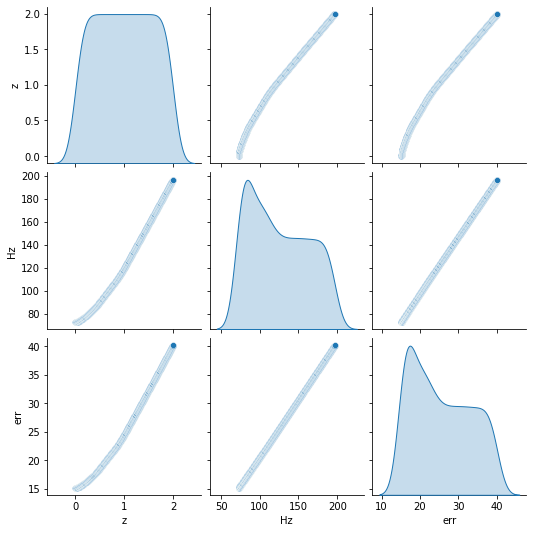

In [48]:
dfMook = pd.DataFrame(mookHz, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50hdmook.png")

In [34]:
# plt.plot(model_train.history['loss'], color='r')
# plt.plot(model_train.history['val_loss'], color='g')
# plt.xlim(1)
# plt.xscale('log')
# plt.ylabel('MSE')
# # plt.yscale('log')
# plt.xlabel('Epoch')
# plt.legend(['train', 'val'], loc='upper right')
# # plt.savefig("loss_hz.png", dpi=200)
# # plt.savefig("epochs_for_Hz.png", dpi=200)

In [13]:
def model2(input_z):
    x = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(200, activation='relu')(x)
    x = Dense(150, activation='relu')(x)
    elast = Dense(2, activation='linear')(x)


    return elast


input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_5 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_6 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 302       
Total params: 40,752
Trainable params: 40,752
Non-trainable params: 0
_________________________________________________________________


#### Now, we not use the statistical error and only use a ANN to given redshift predict $H(z)$. And we estimates its uncertainty with dropout layers.

In [14]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((24, 1), (24, 1), (7, 1), (7, 1))

In [15]:
from astroNN.nn.layers import MCDropout

In [16]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[50, 200, 150])
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=800,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/800
6/6 [==============================] - 0s 24ms/step - loss: 5369.2281 - val_loss: 11047.3262
Epoch 2/800
6/6 [==============================] - 0s 5ms/step - loss: 4644.6811 - val_loss: 11042.3467
Epoch 3/800
6/6 [==============================] - 0s 5ms/step - loss: 4934.5273 - val_loss: 11036.4688
Epoch 4/800
6/6 [==============================] - 0s 5ms/step - loss: 5417.2140 - val_loss: 11039.7510
Epoch 5/800
6/6 [==============================] - 0s 5ms/step - loss: 4808.7423 - val_loss: 11031.3213
Epoch 6/800
6/6 [==============================] - 0s 4ms/step - loss: 5488.5315 - val_loss: 11019.4795
Epoch 7/800
6/6 [==============================] - 0s 5ms/step - loss: 5710.2071 - val_loss: 11013.8857
Epoch 8/800
6/6 [==============================] - 0s 5ms/step - loss: 5454.8132 - val_loss: 11018.0576
Epoch 9/800
6/6 [==============================] - 0s 5ms/step - loss: 4919.7957 - val_loss: 11011.7314
Epoch 10/800
6/6 [==============================] - 0s 5ms/step

6/6 [==============================] - 0s 4ms/step - loss: 2487.0315 - val_loss: 7742.6187
Epoch 80/800
6/6 [==============================] - 0s 4ms/step - loss: 2851.1718 - val_loss: 7585.1782
Epoch 81/800
6/6 [==============================] - 0s 4ms/step - loss: 2556.5762 - val_loss: 7577.0737
Epoch 82/800
6/6 [==============================] - 0s 4ms/step - loss: 2412.0609 - val_loss: 7489.8320
Epoch 83/800
6/6 [==============================] - 0s 4ms/step - loss: 2350.4296 - val_loss: 7210.2319
Epoch 84/800
6/6 [==============================] - 0s 5ms/step - loss: 2780.0948 - val_loss: 7102.3125
Epoch 85/800
6/6 [==============================] - 0s 4ms/step - loss: 1866.7135 - val_loss: 6836.0127
Epoch 86/800
6/6 [==============================] - 0s 4ms/step - loss: 2334.7610 - val_loss: 7099.6758
Epoch 87/800
6/6 [==============================] - 0s 4ms/step - loss: 2242.0738 - val_loss: 6683.5156
Epoch 88/800
6/6 [==============================] - 0s 4ms/step - loss: 1794.

6/6 [==============================] - 0s 5ms/step - loss: 557.0952 - val_loss: 1465.1998
Epoch 158/800
6/6 [==============================] - 0s 4ms/step - loss: 605.5505 - val_loss: 1586.2921
Epoch 159/800
6/6 [==============================] - 0s 4ms/step - loss: 491.2342 - val_loss: 947.9658
Epoch 160/800
6/6 [==============================] - 0s 4ms/step - loss: 523.0606 - val_loss: 865.5986
Epoch 161/800
6/6 [==============================] - 0s 4ms/step - loss: 493.5436 - val_loss: 1064.5665
Epoch 162/800
6/6 [==============================] - 0s 4ms/step - loss: 507.0695 - val_loss: 908.2416
Epoch 163/800
6/6 [==============================] - 0s 4ms/step - loss: 540.4502 - val_loss: 1241.9375
Epoch 164/800
6/6 [==============================] - 0s 4ms/step - loss: 572.4802 - val_loss: 1268.1178
Epoch 165/800
6/6 [==============================] - 0s 4ms/step - loss: 383.9936 - val_loss: 1116.0349
Epoch 166/800
6/6 [==============================] - 0s 4ms/step - loss: 435.3479

6/6 [==============================] - 0s 4ms/step - loss: 290.3211 - val_loss: 374.2454
Epoch 237/800
6/6 [==============================] - 0s 5ms/step - loss: 666.6862 - val_loss: 903.2745
Epoch 238/800
6/6 [==============================] - 0s 4ms/step - loss: 314.4818 - val_loss: 625.2726
Epoch 239/800
6/6 [==============================] - 0s 4ms/step - loss: 482.2742 - val_loss: 608.8405
Epoch 240/800
6/6 [==============================] - 0s 4ms/step - loss: 400.5734 - val_loss: 666.1279
Epoch 241/800
6/6 [==============================] - 0s 4ms/step - loss: 363.5723 - val_loss: 893.2539
Epoch 242/800
6/6 [==============================] - 0s 4ms/step - loss: 280.3870 - val_loss: 607.9005
Epoch 243/800
6/6 [==============================] - 0s 4ms/step - loss: 273.4253 - val_loss: 590.3887
Epoch 244/800
6/6 [==============================] - 0s 4ms/step - loss: 283.7297 - val_loss: 827.3502
Epoch 245/800
6/6 [==============================] - 0s 4ms/step - loss: 454.0904 - val

6/6 [==============================] - 0s 4ms/step - loss: 302.0725 - val_loss: 918.5614
Epoch 316/800
6/6 [==============================] - 0s 4ms/step - loss: 391.9281 - val_loss: 919.8021
Epoch 317/800
6/6 [==============================] - 0s 4ms/step - loss: 399.3469 - val_loss: 648.6854
Epoch 318/800
6/6 [==============================] - 0s 4ms/step - loss: 400.6671 - val_loss: 932.3637
Epoch 319/800
6/6 [==============================] - 0s 4ms/step - loss: 463.7571 - val_loss: 924.1332
Epoch 320/800
6/6 [==============================] - 0s 5ms/step - loss: 189.3921 - val_loss: 582.8138
Epoch 321/800
6/6 [==============================] - 0s 4ms/step - loss: 211.2580 - val_loss: 790.4883
Epoch 322/800
6/6 [==============================] - 0s 5ms/step - loss: 313.1704 - val_loss: 764.7581
Epoch 323/800
6/6 [==============================] - 0s 4ms/step - loss: 265.7904 - val_loss: 568.1522
Epoch 324/800
6/6 [==============================] - 0s 4ms/step - loss: 200.9555 - val

6/6 [==============================] - 0s 4ms/step - loss: 254.4767 - val_loss: 604.8857
Epoch 395/800
6/6 [==============================] - 0s 4ms/step - loss: 199.7956 - val_loss: 816.1034
Epoch 396/800
6/6 [==============================] - 0s 5ms/step - loss: 218.6625 - val_loss: 697.4073
Epoch 397/800
6/6 [==============================] - 0s 4ms/step - loss: 216.9330 - val_loss: 762.7959
Epoch 398/800
6/6 [==============================] - 0s 4ms/step - loss: 267.1596 - val_loss: 319.9742
Epoch 399/800
6/6 [==============================] - 0s 5ms/step - loss: 403.5369 - val_loss: 729.8522
Epoch 400/800
6/6 [==============================] - 0s 4ms/step - loss: 305.8799 - val_loss: 432.7625
Epoch 401/800
6/6 [==============================] - 0s 5ms/step - loss: 224.0527 - val_loss: 599.6808
Epoch 402/800
6/6 [==============================] - 0s 4ms/step - loss: 256.1342 - val_loss: 557.8951
Epoch 403/800
6/6 [==============================] - 0s 4ms/step - loss: 217.6372 - val

6/6 [==============================] - 0s 4ms/step - loss: 422.6989 - val_loss: 374.0920
Epoch 474/800
6/6 [==============================] - 0s 4ms/step - loss: 211.7587 - val_loss: 635.3318
Epoch 475/800
6/6 [==============================] - 0s 4ms/step - loss: 302.0372 - val_loss: 415.7750
Epoch 476/800
6/6 [==============================] - 0s 4ms/step - loss: 433.5338 - val_loss: 603.6073
Epoch 477/800
6/6 [==============================] - 0s 4ms/step - loss: 210.1640 - val_loss: 500.9391
Epoch 478/800
6/6 [==============================] - 0s 4ms/step - loss: 256.8460 - val_loss: 399.5870
Epoch 479/800
6/6 [==============================] - 0s 4ms/step - loss: 212.0228 - val_loss: 382.5024
Epoch 480/800
6/6 [==============================] - 0s 4ms/step - loss: 204.8096 - val_loss: 309.6416
Epoch 481/800
6/6 [==============================] - 0s 4ms/step - loss: 249.6910 - val_loss: 371.2143
Epoch 482/800
6/6 [==============================] - 0s 4ms/step - loss: 221.8359 - val

6/6 [==============================] - 0s 4ms/step - loss: 161.3657 - val_loss: 271.8104
Epoch 553/800
6/6 [==============================] - 0s 4ms/step - loss: 235.4944 - val_loss: 677.3192
Epoch 554/800
6/6 [==============================] - 0s 4ms/step - loss: 179.3115 - val_loss: 471.8824
Epoch 555/800
6/6 [==============================] - 0s 4ms/step - loss: 201.7829 - val_loss: 624.6603
Epoch 556/800
6/6 [==============================] - 0s 6ms/step - loss: 154.9058 - val_loss: 408.8790
Epoch 557/800
6/6 [==============================] - 0s 4ms/step - loss: 175.5648 - val_loss: 681.4964
Epoch 558/800
6/6 [==============================] - 0s 4ms/step - loss: 192.8359 - val_loss: 652.8580
Epoch 559/800
6/6 [==============================] - 0s 4ms/step - loss: 252.4011 - val_loss: 413.7127
Epoch 560/800
6/6 [==============================] - 0s 4ms/step - loss: 551.6005 - val_loss: 798.6351
Epoch 561/800
6/6 [==============================] - 0s 4ms/step - loss: 220.6514 - val

6/6 [==============================] - 0s 4ms/step - loss: 201.2091 - val_loss: 516.0845
Epoch 632/800
6/6 [==============================] - 0s 4ms/step - loss: 197.7298 - val_loss: 401.0396
Epoch 633/800
6/6 [==============================] - 0s 4ms/step - loss: 153.1652 - val_loss: 790.4007
Epoch 634/800
6/6 [==============================] - 0s 4ms/step - loss: 196.1861 - val_loss: 319.3981
Epoch 635/800
6/6 [==============================] - 0s 4ms/step - loss: 207.1181 - val_loss: 387.1725
Epoch 636/800
6/6 [==============================] - 0s 4ms/step - loss: 361.9507 - val_loss: 1241.0908
Epoch 637/800
6/6 [==============================] - 0s 4ms/step - loss: 238.2268 - val_loss: 850.1783
Epoch 638/800
6/6 [==============================] - 0s 4ms/step - loss: 284.3630 - val_loss: 562.6531
Epoch 639/800
6/6 [==============================] - 0s 4ms/step - loss: 248.5895 - val_loss: 609.5153
Epoch 640/800
6/6 [==============================] - 0s 4ms/step - loss: 302.1541 - va

6/6 [==============================] - 0s 4ms/step - loss: 121.1726 - val_loss: 639.6431
Epoch 711/800
6/6 [==============================] - 0s 4ms/step - loss: 193.0103 - val_loss: 583.7084
Epoch 712/800
6/6 [==============================] - 0s 5ms/step - loss: 294.3503 - val_loss: 612.3053
Epoch 713/800
6/6 [==============================] - 0s 4ms/step - loss: 228.9126 - val_loss: 638.7214
Epoch 714/800
6/6 [==============================] - 0s 4ms/step - loss: 195.1164 - val_loss: 628.3043
Epoch 715/800
6/6 [==============================] - 0s 4ms/step - loss: 188.3430 - val_loss: 696.3821
Epoch 716/800
6/6 [==============================] - 0s 4ms/step - loss: 234.9685 - val_loss: 474.9312
Epoch 717/800
6/6 [==============================] - 0s 4ms/step - loss: 282.9290 - val_loss: 1298.2571
Epoch 718/800
6/6 [==============================] - 0s 4ms/step - loss: 189.0725 - val_loss: 675.6138
Epoch 719/800
6/6 [==============================] - 0s 4ms/step - loss: 177.2492 - va

6/6 [==============================] - 0s 4ms/step - loss: 311.0908 - val_loss: 385.7063
Epoch 790/800
6/6 [==============================] - 0s 5ms/step - loss: 241.0831 - val_loss: 410.5565
Epoch 791/800
6/6 [==============================] - 0s 4ms/step - loss: 193.3202 - val_loss: 559.4595
Epoch 792/800
6/6 [==============================] - 0s 5ms/step - loss: 288.2033 - val_loss: 472.9511
Epoch 793/800
6/6 [==============================] - 0s 4ms/step - loss: 147.7712 - val_loss: 419.1899
Epoch 794/800
6/6 [==============================] - 0s 4ms/step - loss: 87.7237 - val_loss: 466.0064
Epoch 795/800
6/6 [==============================] - 0s 4ms/step - loss: 132.5349 - val_loss: 315.2027
Epoch 796/800
6/6 [==============================] - 0s 4ms/step - loss: 216.9095 - val_loss: 406.0415
Epoch 797/800
6/6 [==============================] - 0s 4ms/step - loss: 159.9408 - val_loss: 598.0253
Epoch 798/800
6/6 [==============================] - 0s 4ms/step - loss: 182.1399 - val_

In [17]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [18]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(16.04004094181685, 5.612504937250898)

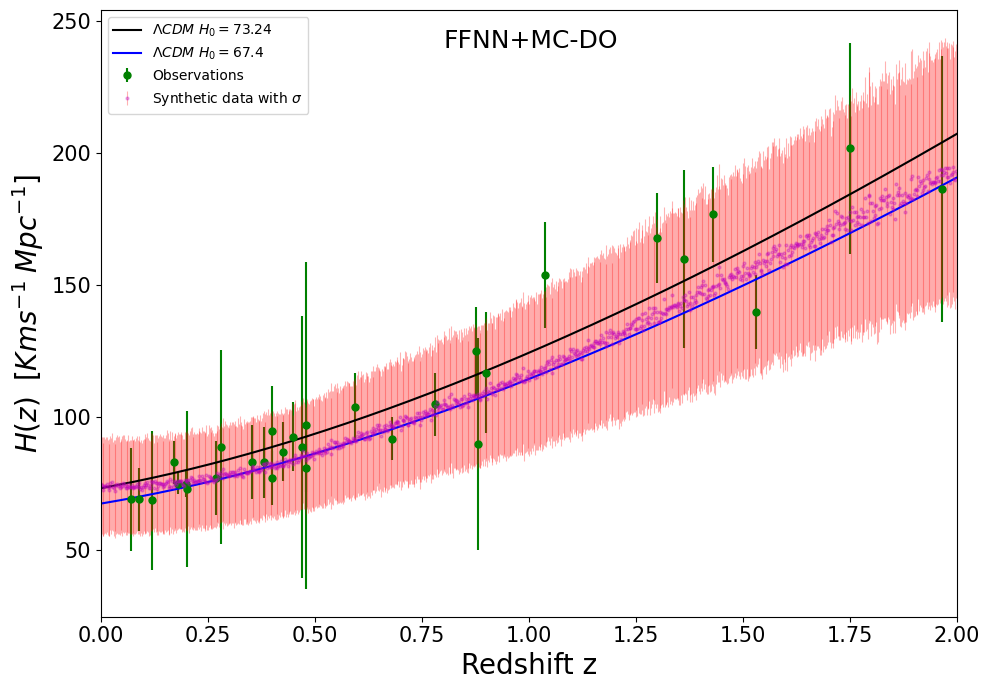

In [115]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')
plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0,2)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.text(0.8, 240, 'FFNN+MC-DO', fontsize=18)
plt.ylabel("$H(z) \;\; [Kms^{-1} \; Mpc^{-1}]$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

plt.savefig('recHZDOl.png')

## $H_0$

In [42]:
 prediction_mc_dropout[0,:]

array([74.73409378, 15.45803553])

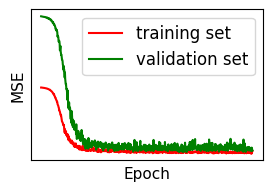

In [101]:
plt.figure(figsize=(3, 2), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.xticks([])
plt.yticks([])
plt.savefig('loss_hz_DO.png')

In [55]:
# model.save('FFNN+MC-DO_Hz.h5')
tf.keras.models.save_model(neural_model2, '../models/FFNN_MC_DO_Hz.h5' )

In [45]:
mookdpHz = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("autoEncoderHz50dropout.dat",mookdpHz, delimiter=" ")

In [46]:
diagcov2 = np.diag(sigma**2) #inverso
# np.savetxt("autoEncoderHz_cov50dropout.dat", diagcov2, delimiter= " ", header="#50 50")

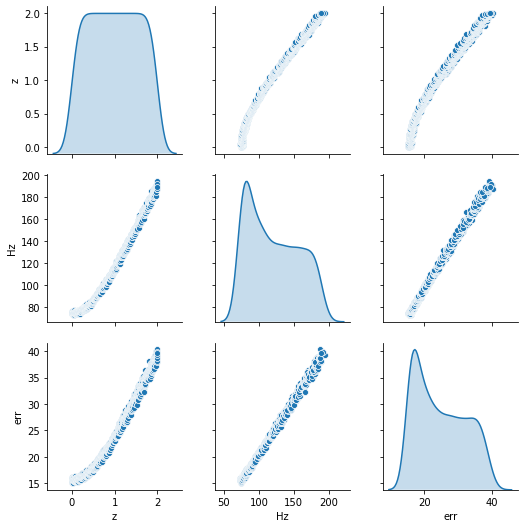

In [47]:
dfMook = pd.DataFrame(mookdpHz, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50hdmookdropout.png")